In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import many_stop_words
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from autocorrect import Speller
from tqdm import tqdm
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder

In [2]:
check = Speller(lang='en')
le = LabelEncoder()

In [3]:
import json

with open("normalize_mapping.json") as normalize_json_file_obj:
    normalize_json = json.load(normalize_json_file_obj)

    

In [4]:
train, test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

In [5]:
#stop_words = list(set(stopwords.words("english")))
lemmatizer = WordNetLemmatizer()
stop_words = many_stop_words.get_stop_words("en")
sb_stemmer = SnowballStemmer(language='english')

In [6]:
train.duplicated().sum()

0

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
set(train.keyword.unique()) - set(test.keyword.unique())

set()

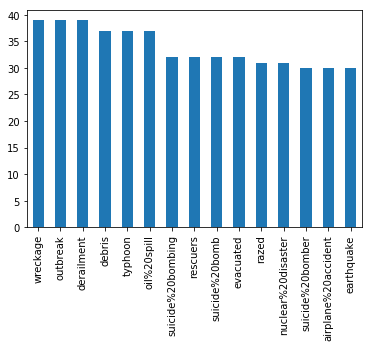

In [10]:
train[(train["target"] == 1)].keyword.value_counts()[0:15].plot.bar()


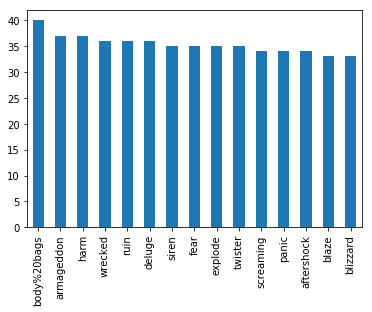

In [11]:
train[(train["target"] == 0)].keyword.value_counts()[0:15].plot.bar()

In [12]:
train["clean_keyword"] = ["Not Available" if pd.isna(each) else each for each in train["keyword"]]
test["clean_keyword"] = ["Not Available" if pd.isna(each) else each for each in test["keyword"]]

In [13]:
train["encoded_clean_keyword"] = le.fit_transform(train["clean_keyword"])
test["encoded_clean_keyword"] = le.transform(test["clean_keyword"])

In [14]:
def clean_text(tweet_df):
    new_tweet_list = []
    for each_tweet in tqdm(tweet_df):
        each_tweet = each_tweet.lower()
        each_tweet = re.sub(r"https?:[^\s]+(?= |$)", "", each_tweet)
        each_tweet = re.sub(r"@[^\s]+", "", each_tweet)
        each_tweet = re.sub(r"&amp;|\||Û|û", "", each_tweet)
        each_tweet = re.sub(r"[^a-z ]", "", each_tweet)
        twitter_slangs = r"|".join(["rt","tweet"])
        each_tweet = re.sub(twitter_slangs, "", each_tweet)
        each_tweet = check(each_tweet)
        each_tweet = " ".join([lemmatizer.lemmatize(each_word) for each_word in each_tweet.split() if each_word not in stop_words])
        each_tweet = " ".join([normalize_json.get(each_word, each_word) for each_word in each_tweet.split()])
        #each_tweet = " ".join([sb_stemmer.stem(each_word) for each_word in word_tokenize(each_tweet) if each_word not in stop_words])

        
        new_tweet_list.append(each_tweet)
    new_tweet_df = pd.DataFrame(new_tweet_list)
    return new_tweet_df
train["clean_text"] = clean_text(train["text"])
test["clean_text"] = clean_text(test["text"])

100%|██████████| 3263/3263 [03:58<00:00, 13.67it/s]


In [15]:
train["clean_text"][train["clean_text"].duplicated()]

48                                                  check
106     ir iceman aftershock dusted trapmusic dub danc...
114     ir iceman aftershock dusted trapmusic dub danc...
115     ir iceman aftershock dusted trapmusic dub danc...
116     ir iceman aftershock dusted trapmusic dub danc...
                              ...                        
7608      giant crane holding bridge collapse nearby home
7609     control wild fire california modern pa troubling
7610                                  tuck volcano hawaii
7611    police investigating bike collided car plural ...
7612    latest home razed modern california wildfire a...
Name: clean_text, Length: 904, dtype: object

In [16]:
train["clean_text"][train[["clean_text", "target"]].duplicated()]

48                                                  check
106     ir iceman aftershock dusted trapmusic dub danc...
114     ir iceman aftershock dusted trapmusic dub danc...
115     ir iceman aftershock dusted trapmusic dub danc...
116     ir iceman aftershock dusted trapmusic dub danc...
                              ...                        
7608      giant crane holding bridge collapse nearby home
7609     control wild fire california modern pa troubling
7610                                  tuck volcano hawaii
7611    police investigating bike collided car plural ...
7612    latest home razed modern california wildfire a...
Name: clean_text, Length: 804, dtype: object

In [17]:
train["clean_text"][(list(set(train["clean_text"][train["clean_text"].duplicated()].index) - set(train["clean_text"][train[["clean_text", "target"]].duplicated()].index)))]

5641            wow nigerian refugee repatriated cameroon
4618    clearedincident injury loop exit md georgia av...
4149          love picked playing barmaid ink listen vote
569     star war power jed collection battle droid ham...
570     black eye space battle occurred star involving...
                              ...                        
6108                          feel sinking selfimage quiz
6634    medium pakistan covered capture terrorist moha...
3060                                     earthquake drill
2039                                               danger
2040    fettilootch slanglucci oppression greatest dan...
Name: clean_text, Length: 100, dtype: object

In [18]:
train = train.drop(list(set(train["clean_text"][train["clean_text"].duplicated()].index) - set(train["clean_text"][train[["clean_text", "target"]].duplicated()].index)))

In [19]:
train["clean_text"][train["clean_text"].duplicated()].count()

804

In [20]:
train = train.drop_duplicates(subset=["clean_text"], keep="first")

In [21]:
train.count()

id                       6709
keyword                  6658
location                 4511
text                     6709
target                   6709
clean_keyword            6709
encoded_clean_keyword    6709
clean_text               6709
dtype: int64

In [22]:
def plot_word_cloud(data):
    wordcloud = WordCloud(width = 2000, height = 2000,
                      background_color='white',
                min_font_size = 10).generate(data) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

## Corpus Word Cloud

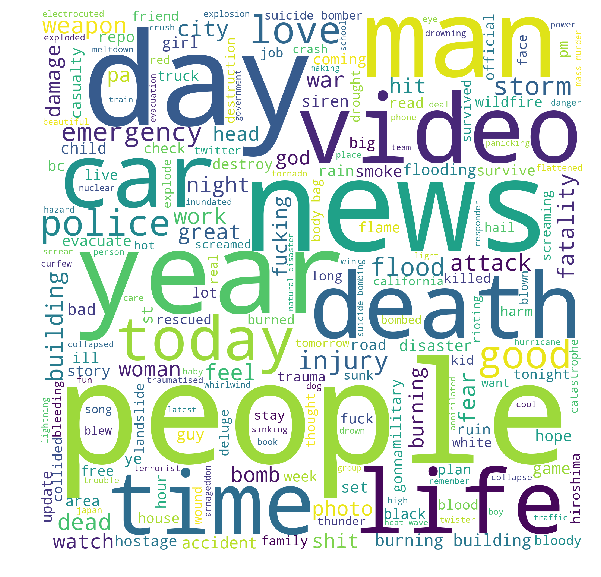

In [23]:
full_data = " ".join(train["clean_text"])
plot_word_cloud(full_data)

## Disaster Tweets Word Cloud

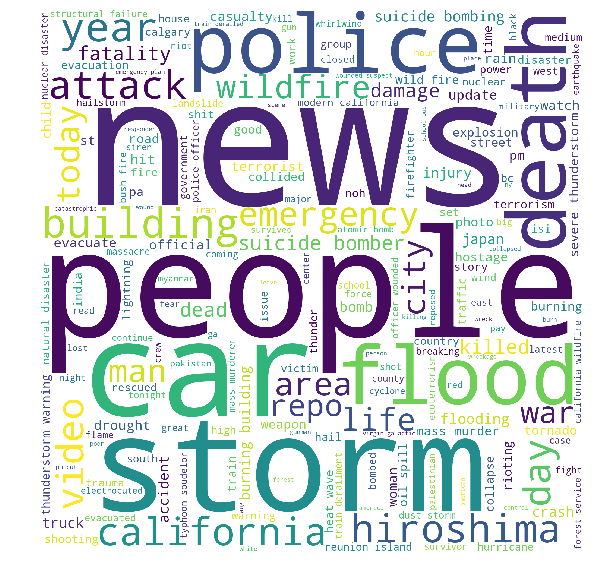

In [24]:
disaster_data = " ".join(train["clean_text"][(train["target"] == 1)])
plot_word_cloud(disaster_data)

## Non Disaster Tweets Word Cloud

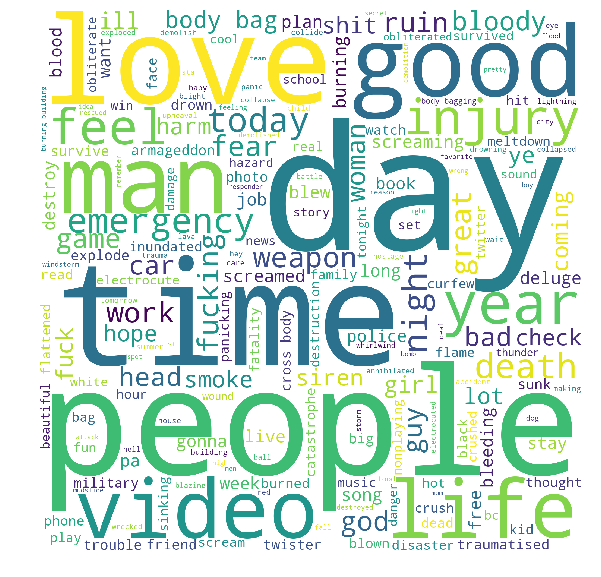

In [25]:
non_disaster_data = " ".join(train["clean_text"][(train["target"] == 0)])
plot_word_cloud(non_disaster_data)

In [26]:
train["target"].value_counts()

0    3950
1    2759
Name: target, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
x_train_df, x_val_df, y_train, y_val = train_test_split(train, train["target"], test_size=0.1)

In [28]:
x_train, x_val, x_test = x_train_df["clean_text"], x_val_df["clean_text"], test["clean_text"]

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2)
train_tfidf = tfidf.fit_transform(x_train)
val_tfidf = tfidf.transform(x_val)
test_tfidf = tfidf.transform(x_test)

# Logistic Regression With Tfidf Values

In [30]:
from sklearn.linear_model import LogisticRegression
logistic_regression_1 = LogisticRegression(C=2, solver="saga")
logistic_regression_1.fit(train_tfidf, y_train)
print(logistic_regression_1.score(train_tfidf, y_train))
print(logistic_regression_1.score(val_tfidf, y_val))

0.8873799271281881
0.7764530551415797


In [31]:
prediction = logistic_regression_1.predict(val_tfidf)

In [33]:
wrong_result = [(sent, each_pre) for index, sent, each_pre, each_or in zip(range(1,len(x_val) + 1), x_val, prediction, y_val) if each_pre != each_or]

In [34]:
wrong_result = pd.DataFrame(wrong_result, columns=["Sentence", "Wrong Label"])
wrong_result.to_csv("wrong_result.csv", index=False)

In [35]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       388
           1       0.78      0.65      0.71       283

    accuracy                           0.78       671
   macro avg       0.78      0.76      0.76       671
weighted avg       0.78      0.78      0.77       671



In [37]:
pred_result_logistic_1 = [each_prediction[1] for each_prediction in logistic_regression_1.predict_proba(val_tfidf)]

Area Under the Curve :  0.8286310152635605


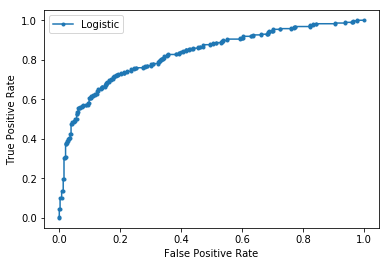

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_val, pred_result_logistic_1)
lr_fpr, lr_tpr, threshold  = roc_curve(y_val, pred_result_logistic_1)
print("Area Under the Curve : ", lr_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
prediction_result = logistic_regression_1.predict(test_tfidf)
output_result = pd.DataFrame()
test_ids_df = pd.DataFrame(test["id"])
output_result["target"] = prediction_result
output = pd.concat([test_ids_df.reset_index(drop=True),output_result.reset_index(drop=True)], axis=1)
output.to_csv("submisson.csv", index=False)